## Parallel Circuits notebook

This notebook describes the `qc_parallelizer` module, its usage in the context of an example, as
well as why the module is useful.

### A. Motivation

In certain quantum computing workloads, it can be the case that there are several smaller\*,
independent\*\* quantum circuits that the user wishes to run, to for instance evaluate results in
some parameter space. Because of the independence, the user might not care about the execution order
or other practicalities related to how the circuits are run.

With existing, commonly-used tooling, executing such a set of circuits can lead to a rather naive
and unoptimized setting, where each circuit is run strictly sequentially. With the introduction
of larger QPU architectures with more qubits, this becomes increasingly wasteful &mdash; especially
if there is overhead in circuit execution, e.g. in uploading circuit data to the control electronics
&mdash; since only a part of the chip is in use at once.

The `qc_parallelizer` module allows the user to transform the list of circuits into larger, combined
circuits, that pack as many user-defined circuits as the QPU can natively process. It provides a
simple set of functions for performing this transformation as well as executing the circuits in a
way that makes parallelization invisible to the user, by returning results from each individual
circuit separately.

Ideally, the user need not make any adjustments in their code &mdash; the module is intended to work
as a direct replacement/addition for `backend.run()`.

*) Low circuit width, where the number of utilized qubits << number of available qubits.<br>
**) Circuits that do not share qubits or depend on results from each other.

### B. Limitations

This technique comes with some limitations and drawbacks:
- **Crosstalk**: a very densely utilized backend will probably contain physically neighboring qubits
  that do not share any operations virtually. However, since physical coupling is fixed, slight
  errors can be introduced between qubits that should not couple. This can be avoided, but it comes
  at a cost of less dense packing, which leads to more circuits, which leads to longer execution
  times.
- **Limited parallelization due to limited connectivity**: two circuits do _not_ fit onto the same
  backend automatically if they collectively use less qubits than what the backend supports. The
  backend must also support coupling between qubits where it is needed, since introducing swap
  operations within circuits has costs that outweigh the benefits (namely, lower execution time) of
  parallelization.

### C. General operation diagram

The diagram below describes the general operation of the parallelizer. The light blue boxes in the
lower half correspond to functions that the `qc_parallelizer` module exposes as its public
interface.

![Parallelizer operation diagram](./parallelizer-full.drawio.png)

### 1. Environment and dependencies

> **Note on import styles:** This notebook does not import anything into global context without a
  prefix (i.e. the `from ... import ...` kind) to clarify which objects and functions come from
  which modules.

The module is closely tied to Qiskit and depends on it. Consequently, circuits must also be built
with Qiskit's `QuantumCircuit` model. Furthermore, we use IQM's quantum computer backends, as well
as Matplotlib for plots. The full list of dependencies is specified in the project's
`pyproject.toml` file.

With e.g. Conda, one can easily set up an environment with the following commands. Make sure to run
them from the project's root directory.

```bash
conda create --name parallelizer python=3.10 pip # Note the Python version!
conda activate parallelizer
pip install .[notebooks]
```

Once this is set up, we can import these packages for usage.

In [1]:
import iqm.qiskit_iqm as iqm
import matplotlib.pyplot as plt
import qiskit

print(f"Qiskit version is {qiskit.version.get_version_info()}!")

Qiskit version is 0.45.3!


Below we also import the module itself. This makes the provided functionality accessible under the
`parallelizer` name.

In [2]:
import qc_parallelizer as parallelizer

Since we are dealing with lists of circuits in this notebook, we also define convenient helper
functions for drawing multiple circuits and histograms into one plot. Note the `kwargs` parameter,
which lets us pass parameters to the underlying calls to the draw functions. The plots are also
drawn with a non-default DPI of 300, which makes larger plots clearer (but larger).

In [3]:
def plot_circuits(circuits, figsize=None, **kwargs):
    if len(circuits) > 0 and not isinstance(circuits[0], list):
        circuits = [circuits]
    nrows, ncols = len(circuits), max(len(row) for row in circuits)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, dpi=300, figsize=figsize)
    circuit_index = 0
    for i, row in enumerate(circuits):
        for j, circuit in enumerate(row):
            ax = (
                axs[i, j]
                if nrows > 1 and ncols > 1
                else axs[j]
                if ncols > 1
                else axs[i]
                if nrows > 1
                else axs
            )
            circuit.draw(output="mpl", style="clifford", ax=ax, **kwargs)
            ax.set_title(circuit.name or f"Circuit {circuit_index}")
            circuit_index += 1
    plt.tight_layout()
    plt.show()


def plot_histograms(counts, figsize=None, **kwargs):
    fig, axs = plt.subplots(nrows=1, ncols=len(counts), dpi=300, figsize=figsize)
    for i, count_dict in enumerate(counts):
        ax = axs[i] if len(counts) > 1 else axs
        qiskit.visualization.plot_histogram(count_dict, ax=ax, **kwargs)
        ax.set_title(f"Histogram {i}")
    plt.tight_layout()
    plt.show()

### 2. Define example circuits

In the absence of a real-world example, we construct four simple quantum circuits, two with a
single qubit and two with two qubits. The last circuit is more special, in that it uses named
classical registers &mdash; this is to demonstrate how the parallelizer preserves name information
through transformations. We also demonstrate metadata preservation with the `metadata` argument.

In [4]:
def create_ghz_circuit(num_qubits, metadata=None):
    circuit = qiskit.QuantumCircuit(num_qubits, metadata=metadata)
    circuit.h(0)
    for i in range(1, num_qubits):
        circuit.cx(0, i)
    circuit.measure_active()
    return circuit


def create_all_ones_circuit(num_qubits, metadata=None):
    circuit = qiskit.QuantumCircuit(num_qubits, metadata=metadata)
    circuit.x(list(range(num_qubits)))
    circuit.measure_active()
    return circuit


def create_named_reg_circuit(metadata=None):
    qreg = qiskit.QuantumRegister(2)
    cregs = [qiskit.ClassicalRegister(1, "bit_one"), qiskit.ClassicalRegister(1, "bit_two")]
    circuit = qiskit.QuantumCircuit(qreg, *cregs, metadata=metadata)
    circuit.h(qreg[0])
    circuit.cx(qreg[0], qreg[1])
    circuit.measure(qreg[0], cregs[0][0])
    circuit.measure(qreg[1], cregs[1][0])
    return circuit


circuits = [
    create_ghz_circuit(num_qubits=1, metadata={"foo": {"bar": "baz"}}),
    create_all_ones_circuit(num_qubits=1),
    create_ghz_circuit(num_qubits=2),
    create_named_reg_circuit(metadata={"tag": "hotel-alpha"}),
]

Now, with the helper function from above, we can visualize these circuits.

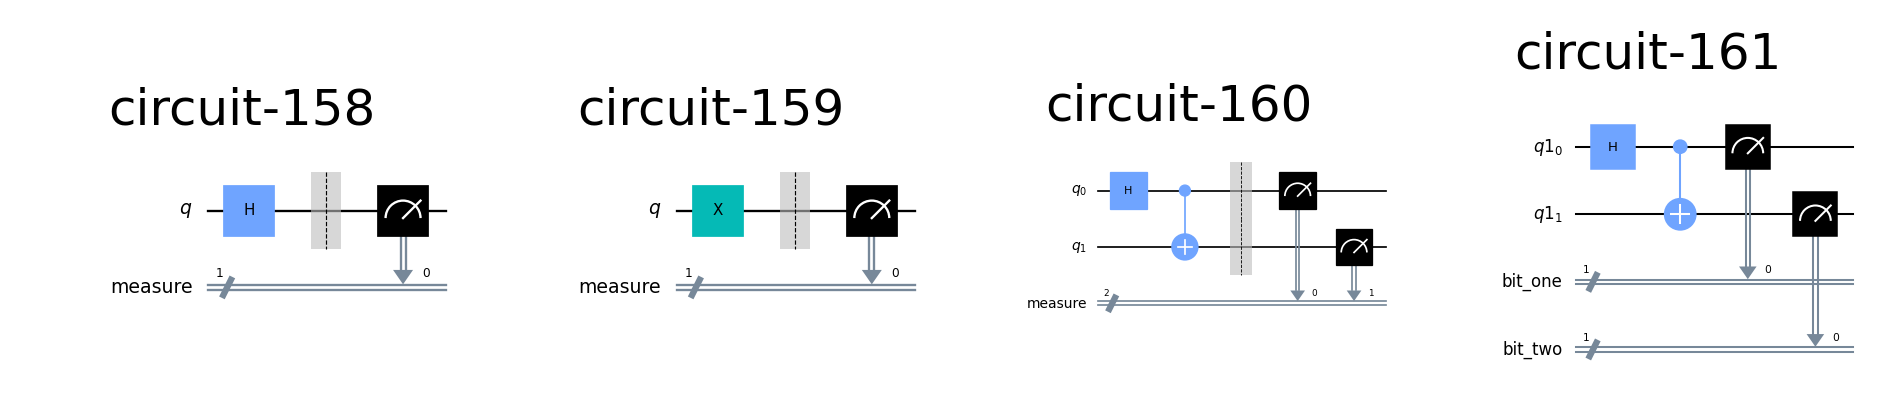

In [5]:
plot_circuits(circuits)

### 3. Define and retrieve backend objects

The parallelizer does not make much sense without information about the quantum computer backend(s)
that we want to work with. We are using `IQMFakeAdonis` to work with a fake IQM backend with five
qubits.

In this example, we create two instances of the backend to simulate two separate backends.

You may also use any `BackendV2`-compatible backend with e.g. `IQMProvider`, which is implemented
but commented out below. This notebook does not explain how one can find the device URL and access
token, though &mdash; please see other resources for that.

In [6]:
# Use a server backend
# import os
# os.environ["IQM_TOKEN"] = "YOUR_TOKEN_HERE"
# backends = [iqm.IQMProvider("DEVICE_URL_HERE").get_backend()]

# Use local simulator backends
backends = [iqm.IQMFakeAdonis(), iqm.IQMFakeAdonis()]

print(f"{' + '.join(str(backend.num_qubits) for backend in backends)} qubits available.")

5 + 5 qubits available.


### 4. Circuit layouts (inapplicable to this example)

Because we are using multiple backends, we cannot provide layout information for parallelization.
However, doing so would be easy, as demonstrated below. If the second line was not commented out,
the parallelizer would place the two qubits on the circuit at index 2 onto qubits 0 and 2 (QB1 and
QB3 on Adonis).

In [7]:
circuit_2_layout = [0, 2]
# circuits[2] = (circuits[2], circuit_2_layout)

Generally, each circuit in the circuit list must be either
- a `QuantumCircuit` object, in which case the parallelizer chooses a layout for it, or
- a `(QuantumCircuit, Layout | dict | list)` tuple, where the second element is the desired layout.
  The layout can be in any form that Qiskit would accept. Note that if present, the layout must be
  complete, that is, defined for the entire circuit. Providing an incomplete layout will raise an
  exception.

All given circuits need not have a defined layout &mdash; you may pass any desired mixture of
circuits with and without layouts, and the parallelizer will fill in the missing information in a
way that it sees fit.

### 5. Note on transpilation

As indicated by the [operation diagram at the top](#c-general-operation-diagram), the parallelizer
will transpile circuits so that they are compatible with the assigned backends. However, since there
may be situations where the parallelizer should not introduce any optimization or other
unnecessary transformations on the circuit, transpilation is only used to a minimal extent &mdash;
converting to the native gate set and introducing required SWAP gates, if necessary.

Therefore, if you wish to transpile a circuit with optimizations enabled, please run it through
`qiskit.transpile()` first. The parallelizer can work with both untranspiled and transpiled
circuits. Problems may arise when a circuit has been optimized for one backend but the parallelizer
chooses to place it on another &mdash; this is a current technical limitation, and it is recommended
to parallelize circuits for only one backend at a time if such optimizations are used.

### 6. Rearrange the circuits

Now that we have circuits and backends defined, we can rearrange our circuits to be ready for
parallel execution. The function call for that is very simple, _requiring_ only two parameters
(but see below for information on the optional parameters).

In [8]:
parallel_circuits = parallelizer.rearrange(circuits, backends)

> **Note:** calling `parallelizer.rearrange()` in a separate step is not necessary. One may also
  pass the original circuit list directly to `parallelizer.execute()` (below), which will perform
  any required preprocessing automatically.

> **Note #2:** this call is potentially very expensive computationally. The parallelizer must
  transpile circuits so that they fit the given backend(s), potentially for several backends, and
  potentially several times for multiple backend "bins", or collections of circuits for a given
  backend. Of course the parallelizer does not intentionally waste CPU cycles, but it is a complex
  puzzle with many pieces. Some thought should thus be given to when/how this function is called
  when the inputs are large.

Now, to see what this did, we can use `.describe()`:

In [9]:
print(parallelizer.describe(parallel_circuits))

2 backends
 - IQMFakeAdonisBackend (5 qubits, 1 circuit)
   Min 2 / avg 2.0 / max 2 hosted circuits per physical circuit
 - IQMFakeAdonisBackend (5 qubits, 1 circuit)
   Min 2 / avg 2.0 / max 2 hosted circuits per physical circuit


That's nice, but how do the circuits look like? We can again use the plotting function to visualize
them. The output of the cell below should only contain two circuits that "host" all four original
circuits.

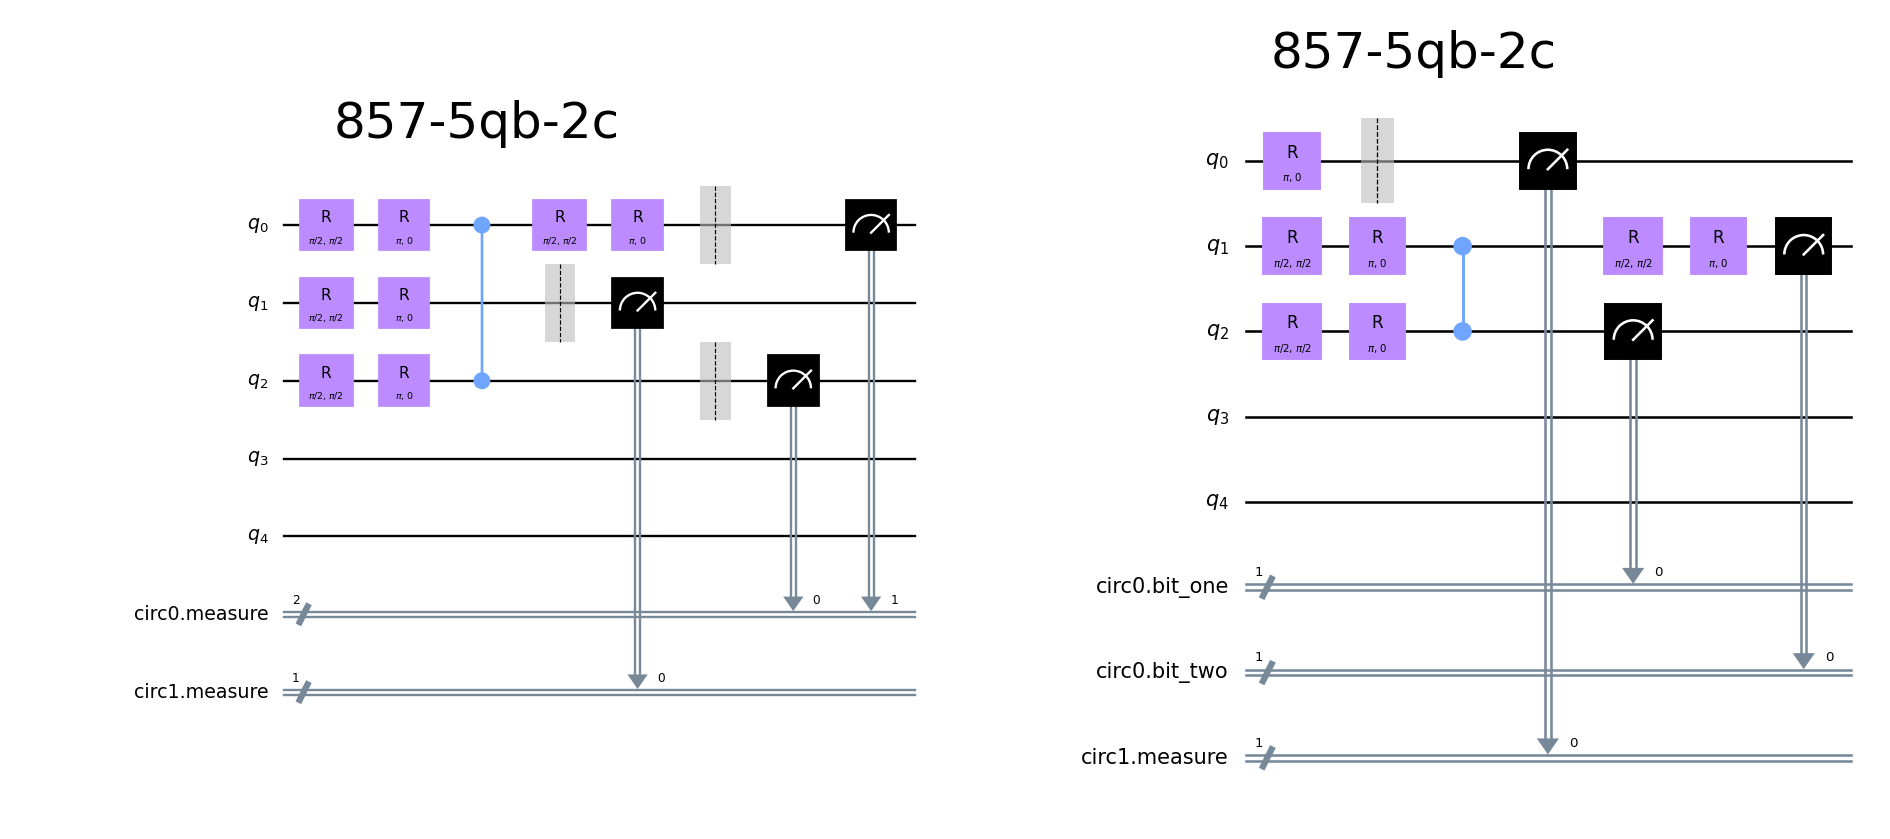

In [10]:
plot_circuits([circuit for circuits in parallel_circuits.values() for circuit in circuits])

The cryptic labels above each circuit identify the circuit, but also provide some information about
what they contain. The label is of the form `[hash]-[qubit count]qb-[circuit count]c`.

The rearranging step also embeds some metadata into the circuit objects. The user need (and often
must) not modify the metadata &mdash; the parallelizer uses it internally to track which circuits
have been partitioned and information about the original circuits. The original metadata is also
preserved, in case accessing that later is desired.

For those that are curious, the commented code in the cell below can be used to view said metadata.

In [11]:
# import json
# first_circuit = next(iter(parallel_circuits.values()))[0]
# print(json.dumps(first_circuit.metadata, indent=4))

Additionally, `parallelizer.rearrange()` accepts a few keyword arguments to control circuit
arrangement and parallelization:

| Name | Default | Description |
| -----| ------- | ----------- |
| `packpol` | `DefaultPackingPolicy()` | See the next section. |
| `allow_ooe` (allow out-of-order execution) | `True` | If `False`, circuits must be executed strictly in order. A circuit that comes earlier than another circuit is executed latest in parallel with the later circuit. If `True`, the parallelizer is free to reorder circuits to achieve a more optimal packing. |
| `transpiler_seed` | `0` | This will be included in numerical seeds that are passed to transpiler stages that may vary from execution to execution. By default, the value is fixed, so results will always be consistent, but that can be changed by passing a random value here. |

### 7. Note on packing policies

Different packing policies might be desired in different situations. By default, the parallelizer
will pack circuits densely, which places qubits solely based on physical coupler constraints, and
does not consider unwanted neighbors.

Currently, only one packer policy is built in, `DefaultPackingPolicy`. The class constructor accepts
one boolean parameter, `allow_nb`, which can be used to control how densely circuits are packed
&mdash; when `True`, circuits can be placed wherever there is space and required couplers, and when
`False`, the parallelizer must leave at least one unused qubit (i.e. two couplers) between circuits.

Custom packer policies can be defined as well. The `packing` module defines an abstract base class,
`PackingPolicyBase`, which you may subclass. Please see
[the source code](../src/qc_parallelizer/packing.py) for more details and what
implementations must define or provide.

**Note:** the policy system is still somewhat a work in progress.

### 8. Execute the circuits

Finally, now that we have everything that we need, we may submit the circuit(s) for execution. This
is done with another simple function call. If you wish to pass arguments to the underlying call to
`backend.run()`, you may pass a dictionary in an argument called `run_args`. Likewise, if you
skipped calling `parallelizer.rearrange()`, you can pass arguments to that in `rearrange_args`.

Note that **this won't block** for results until we call `parallel_job.results()` later.

In [12]:
parallel_job = parallelizer.execute(parallel_circuits)

Now we might have to wait a bit &mdash; one job with the corresponding backend's assigned circuits
has been sent to each backend.

Eventually, we can fetch and visualize the results with the other helper function from above. We can
also verify that the circuit order as well as original metadata is indeed preserved. As shown below,
attributes on how the circuits were parallelizer can be read from `parallel_job.info`.

Execution statistics:
 - Min | max | avg backend load:   1 | 1 | ~1.0 c/b
 - Num circuits | backends | jobs: 2 | 2 | 2
Job IDs:
 - d3641589-61a3-4065-a1c2-e74a7803f32c
 - 2c260408-2e56-45e3-89a8-942552304b53
Metadata #0: {'foo': {'bar': 'baz'}}
Metadata #1: {}
Metadata #2: {}
Metadata #3: {'tag': 'hotel-alpha'}


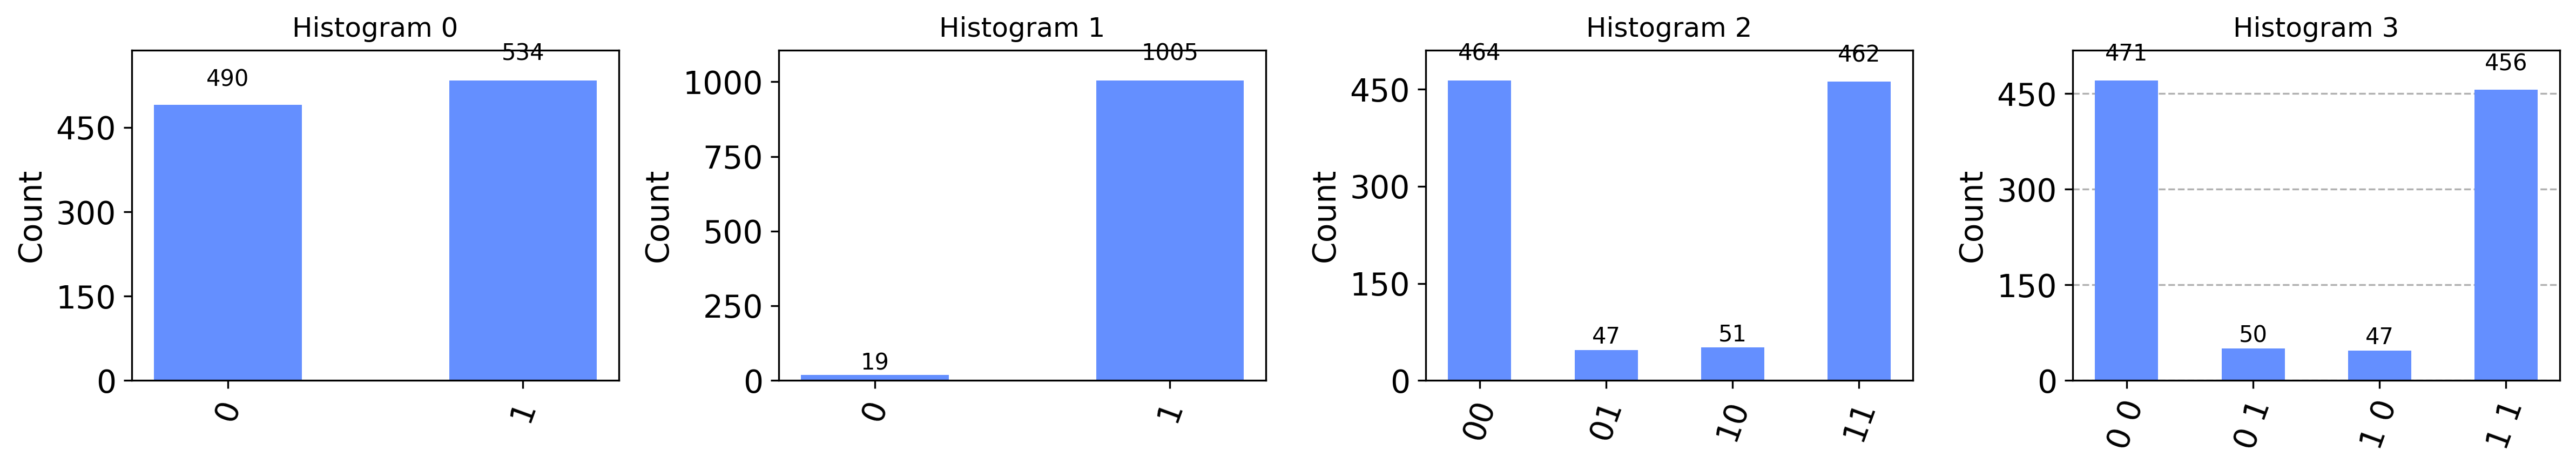

In [13]:
results = parallel_job.results()

load_min, load_max, load_avg = (
    parallel_job.info.min_circuits_per_backend,
    parallel_job.info.max_circuits_per_backend,
    parallel_job.info.avg_circuits_per_backend,
)
num_c, num_b, num_j = (
    parallel_job.info.num_circuits,
    parallel_job.info.num_backends,
    parallel_job.info.num_jobs,
)

print("Execution statistics:")
print(f" - Min | max | avg backend load:   {load_min} | {load_max} | ~{load_avg} c/b")
print(f" - Num circuits | backends | jobs: {num_c} | {num_b} | {num_j}")
print("Job IDs:")
for job_id in parallel_job.job_id():
    print(f" - {job_id}")

for i, result in enumerate(results):
    print(f"Metadata #{i}:", result.header.metadata)

plot_histograms([result.get_counts() for result in results], figsize=(16, 3))

### This concludes the Parallel Circuits notebook!

Consider what happened under the hood: our four example circuits were combined into two host
circuits and then executed in parallel on two separate backends. However, as a user, you do not
deal with any of this directly, and can work with circuits and results in a sequential manner.